In [1]:
import os
import math
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import threestudio
import gc
import time
import io

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5):

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, -1)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
# To specify the gpu you want to use, we recommend to start the jupyter server with CUDA_VISIBLE_DEVICES=<gpu_ids>.
# threestudio.utils.base.get_device = lambda: torch.device('cuda:0') # hack the cuda device

/opt/conda/lib/python3.9/site-packages/tinycudann/modules.py:52: UserWarning: tinycudann was built for lower compute capability (75) than the system's (86). Performance may be suboptimal.
  warnings.warn(f"tinycudann was built for lower compute capability ({cc}) than the system's ({system_compute_capability}). Performance may be suboptimal.")
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [2]:
# Autoreload
%load_ext autoreload
%autoreload 2

In [3]:
# stable diffusion 

config = {
    'max_iters': 1000,
    'seed': 42,
    'scheduler': 'cosine',
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-prompt-processor',
    'prompt_processor': {
        'prompt': 'a pineapple',
        # 'view_dependent_prompting': False,
    },
    'guidance_type': 'stable-diffusion-guidance',
    'guidance': {
        'half_precision_weights': False,
        'guidance_scale': 100.,
        'pretrained_model_name_or_path': 'runwayml/stable-diffusion-v1-5',
        'grad_clip': None,
    },
    'image': {
        'width': 64,
        'height': 64,
    }
}

# deepfloyd

# config = {
#     'max_iters': 1000,
#     'seed': 42,
#     'scheduler': 'cosine',
#     'mode': 'rgb', # deepfloyd does not support latent optimization
#     'prompt_processor_type': 'deep-floyd-prompt-processor',
#     'prompt_processor': {
#         'prompt': 'a pineapple',
#         'view_dependent_prompting': False,
#     },
#     'guidance_type': 'deep-floyd-guidance',
#     'guidance': {
#         'half_precision_weights': True,
#         'guidance_scale': 7.,
#         'pretrained_model_name_or_path': 'DeepFloyd/IF-I-XL-v1.0',
#         'grad_clip': None,
#     },
#     'image': {
#         'width': 64,
#         'height': 64,
#     }
# }

seed_everything(config['seed'])

In [4]:
# just need to rerun the cell when you change guidance or prompt_processor
guidance = None
prompt_processor = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

guidance = threestudio.find(config['guidance_type'])(config['guidance'])
prompt_processor = threestudio.find(config['prompt_processor_type'])(config['prompt_processor'])
prompt_processor.configure_text_encoder()

Loading Stable Diffusion ...
Loaded Stable Diffusion!
Using prompt [a pineapple] and negative prompt []


In [8]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def configure_other_guidance_params_manually(guidance, config):
    # avoid reloading guidance every time change these params
    guidance.cfg.grad_clip = config['guidance']['grad_clip']
    guidance.cfg.guidance_scale = config['guidance']['guidance_scale']

    print("grad_clip", guidance.cfg.grad_clip)

def run(config):
    # clear gpu memory
    rgb = None
    grad = None
    vis_grad = None
    vis_grad_norm = None
    loss = None
    optimizer = None
    target = None
    cond_embeddings, uncond_text_embeddings = None, None
    text_embeddings = None

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    
    configure_other_guidance_params_manually(guidance, config)

    prompt = config['prompt_processor']['prompt']
    negative_prompt = ''
    mode = config['mode']
    
    w, h = config['image']['width'], config['image']['height']
    if mode == 'rgb':
        target = nn.Parameter(torch.rand(1, h, w, 3, device=guidance.device))
    else:
        target = nn.Parameter(torch.randn(1, h, w, 4, device=guidance.device))

    optimizer = torch.optim.AdamW([target], lr=1e-1, weight_decay=0)
    num_steps = config['max_iters']
    scheduler = get_cosine_schedule_with_warmup(optimizer, 100, int(num_steps*1.5)) if config['scheduler'] == 'cosine' else None

    # avoid loadgin prompt_processor multi times
    cond_embeddings, uncond_text_embeddings = prompt_processor.get_text_embeddings(prompt, negative_prompt)
    text_embeddings = torch.cat([cond_embeddings, uncond_text_embeddings], dim=0)

    rgb = None
    plt.axis('off')

    img_array = []

    try:
        for step in tqdm(range(num_steps + 1)):
            optimizer.zero_grad()

            batch = {
                'elevation': torch.Tensor([0]),
                'azimuth': torch.Tensor([0]),
                'camera_distances': torch.Tensor([1]),
            }

            loss = guidance(target, prompt_processor(), **batch, rgb_as_latents=(mode != 'rgb'))
            # ext_embeddings=text_embeddings, rgb_as_latents=(mode != 'rgb'))
            loss['loss_sds'].backward()

            grad = target.grad
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            guidance.update_step(epoch=0, global_step=step)

            if step % 5 == 0:

                print(loss['loss_sds'].item(), "Loss")
                print(target.min(), target.max(), "Target")

                if mode == 'rgb':
                    rgb = target
                    vis_grad = grad[..., :3]
                    vis_grad_norm = grad.norm(dim=-1)
                else:
                    rgb = guidance.decode_latents(target.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
                    vis_grad = grad
                    vis_grad_norm = grad.norm(dim=-1)
                
                vis_grad_norm = vis_grad_norm / vis_grad_norm.max()
                vis_grad = vis_grad / vis_grad.max()
                img_rgb = rgb.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad = vis_grad.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad_norm = vis_grad_norm.clamp(0, 1).detach().squeeze(0).cpu().numpy()

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(img_rgb)
                ax[1].imshow(img_grad)
                ax[2].imshow(img_grad_norm)
                ax[0].axis('off')
                ax[1].axis('off')
                ax[2].axis('off')
                # clear_output(wait=True)
                plt.show()
                img_array.append(figure2image(fig))
    except KeyboardInterrupt:
        pass
    finally:
        # browse the result
        print("Optimizing process:")
        images = img_array
        
        if len(images) > 0:
            # Set up the widgets
            slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
            output = Output()

            def display_image(index):
                with output:
                    output.clear_output(wait=True)
                    display(images[index])

            # Link the slider to the display function
            interact(display_image, index=slider)

            # Display the widgets
            # display(slider)
            display(output)

grad_clip None


  0%|          | 0/1001 [00:00<?, ?it/s]


Optimizing process:


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 config['mode'] = 'latent'                                                                    │
│ ❱ 2 run(config)                                                                                  │
│   3                                                                                              │
│                                                                                                  │
│ in run:66                                                                                        │
│                                                                                                  │
│    63 │   │   │   │   'camera_distances': torch.Tensor([1]),                                     │
│    64 │   │   │   }                                                                              │
│    65 │   │   │                                                                                  │
│ ❱  66 │   │   │   loss = guidance(target, prompt_processor(), **batch, rgb_as_latents=(mode !=   │
│    67 │   │   │   # ext_embeddings=text_embeddings, rgb_as_latents=(mode != 'rgb'))              │
│    68 │   │   │   loss['loss_sds'].backward()                                                    │
│    69                                                                                            │
│                                                                                                  │
│ /mnt/data/threestudio/threestudio/models/guidance/stable_diffusion_guidance.py:283 in __call__   │
│                                                                                                  │
│   280 │   │   #     elevation, azimuth, camera_distances, self.cfg.view_dependent_prompting      │
│   281 │   │   # )                                                                                │
│   282 │   │                                                                                      │
│ ❱ 283 │   │   text_embeddings = self.pipe._encode_prompt(                                        │
│   284 │   │   │   "A cat",                                                                       │
│   285 │   │   │   self.device,                                                                   │
│   286 │   │   │   1,                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diff │
│ usion.py:329 in _encode_prompt                                                                   │
│                                                                                                  │
│   326 │   │   if prompt_embeds is None:                                                          │
│   327 │   │   │   # textual inversion: procecss multi-vector tokens if necessary                 │
│   328 │   │   │   if isinstance(self, TextualInversionLoaderMixin):                              │
│ ❱ 329 │   │   │   │   prompt = self.maybe_convert_prompt(prompt, self.tokenizer)                 │
│   330 │   │   │                                                                                  │
│   331 │   │   │   text_inputs = self.tokenizer(                                                  │
│   332 │   │   │   │   prompt,                                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/diffusers/loaders.py:384 in maybe_convert_prompt          │
│                                                            

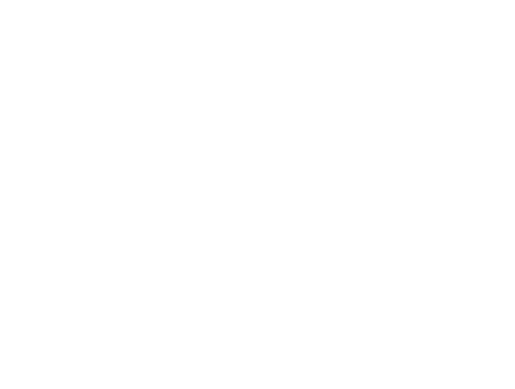

In [9]:
config['mode'] = 'latent'
run(config)

grad_clip None


  0%|          | 0/1001 [00:00<?, ?it/s]

7672.0009765625 Loss
tensor(5.8355e-05, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9999, device='cuda:0', grad_fn=<MaxBackward1>) Target


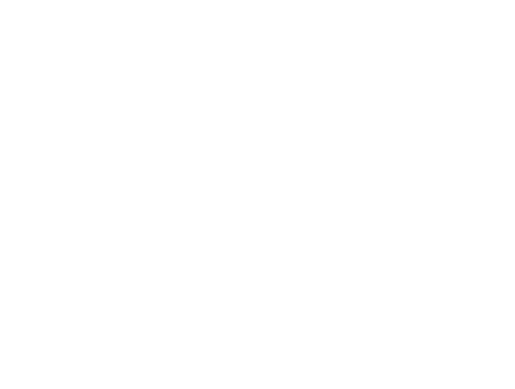

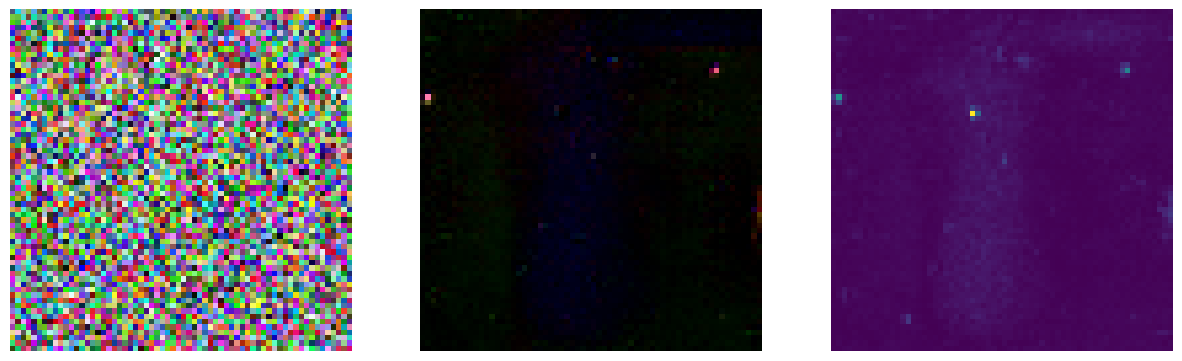

  0%|          | 5/1001 [00:01<06:05,  2.72it/s]

3991.5009765625 Loss
tensor(-0.0101, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0104, device='cuda:0', grad_fn=<MaxBackward1>) Target


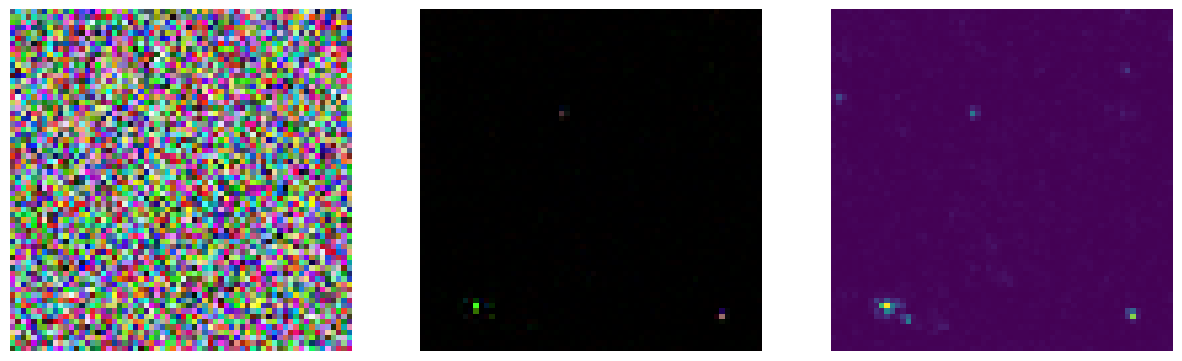

  1%|          | 10/1001 [00:03<06:14,  2.65it/s]

6548.43212890625 Loss
tensor(-0.0359, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0346, device='cuda:0', grad_fn=<MaxBackward1>) Target


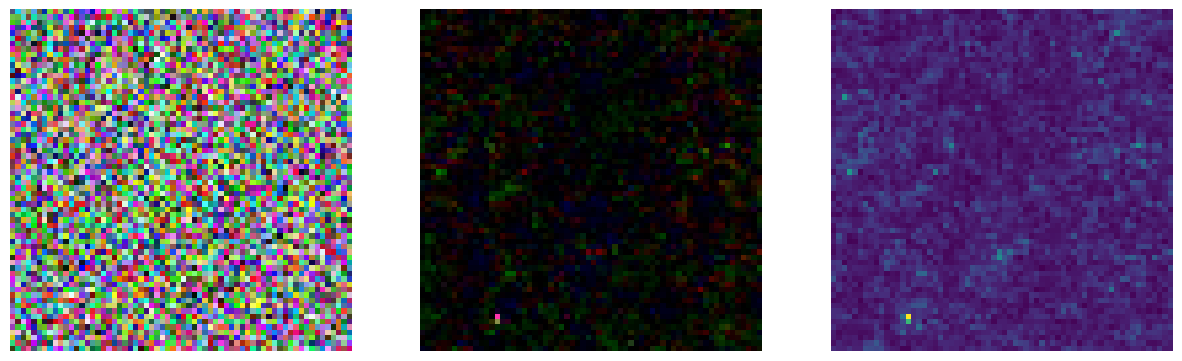

  1%|▏         | 15/1001 [00:05<06:16,  2.62it/s]

1170.1572265625 Loss
tensor(-0.0837, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0707, device='cuda:0', grad_fn=<MaxBackward1>) Target


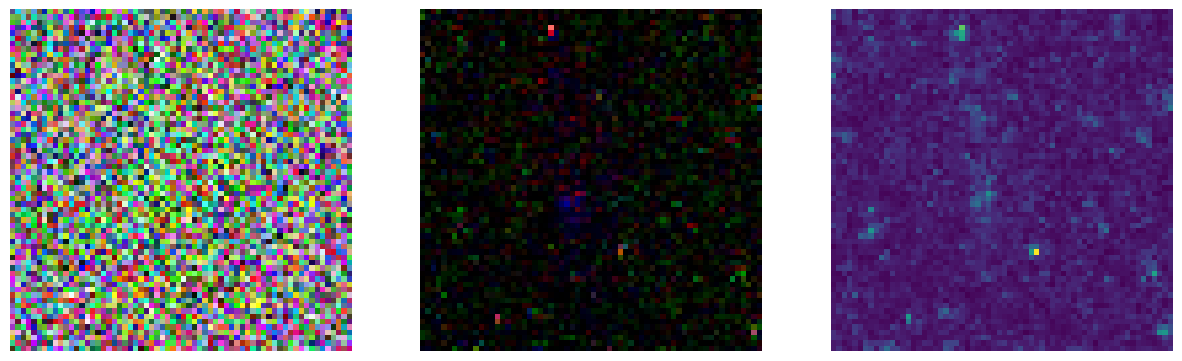

  2%|▏         | 20/1001 [00:07<06:15,  2.61it/s]

23463.216796875 Loss
tensor(-0.1290, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1311, device='cuda:0', grad_fn=<MaxBackward1>) Target


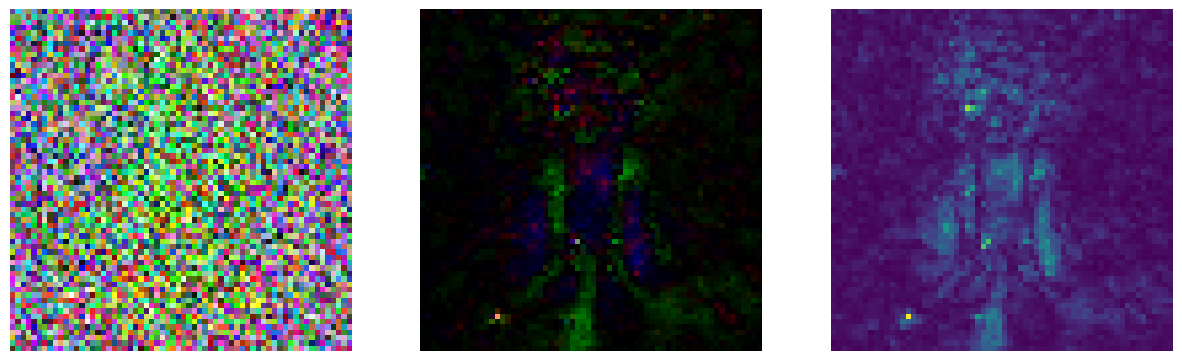

  2%|▏         | 25/1001 [00:09<06:13,  2.62it/s]

33252.3828125 Loss
tensor(-0.2282, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2091, device='cuda:0', grad_fn=<MaxBackward1>) Target


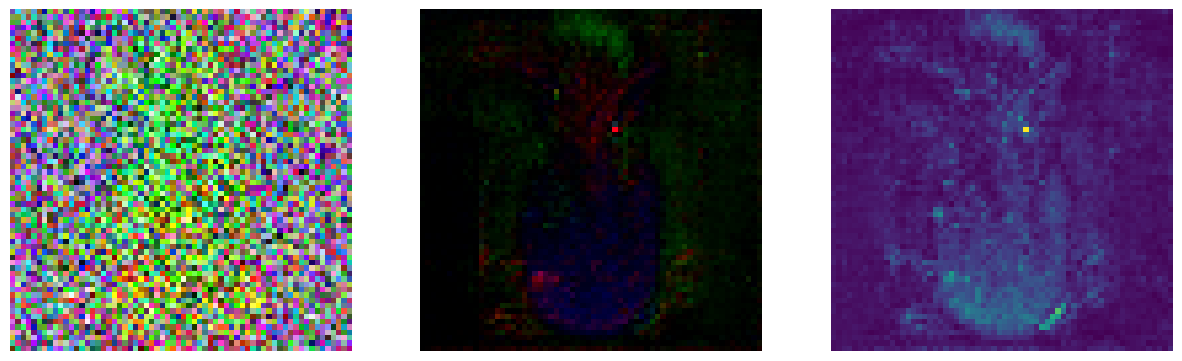

  3%|▎         | 30/1001 [00:12<06:10,  2.62it/s]

59637.328125 Loss
tensor(-0.3287, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.3059, device='cuda:0', grad_fn=<MaxBackward1>) Target


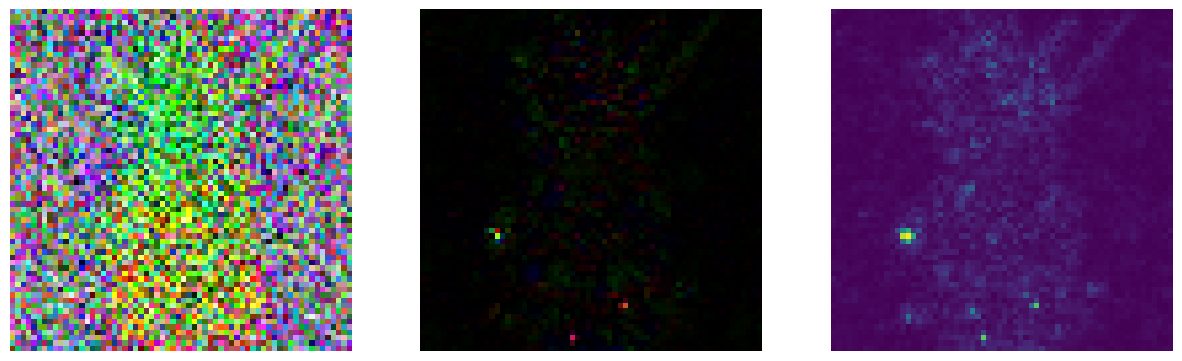

  3%|▎         | 35/1001 [00:14<06:10,  2.61it/s]

60807.5625 Loss
tensor(-0.4493, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4198, device='cuda:0', grad_fn=<MaxBackward1>) Target


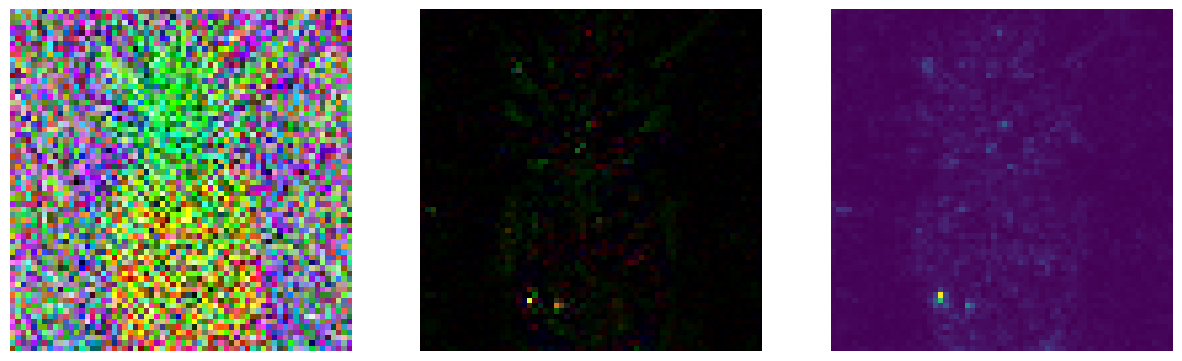

  4%|▍         | 40/1001 [00:16<06:05,  2.63it/s]

27527.32421875 Loss
tensor(-0.5934, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.4962, device='cuda:0', grad_fn=<MaxBackward1>) Target


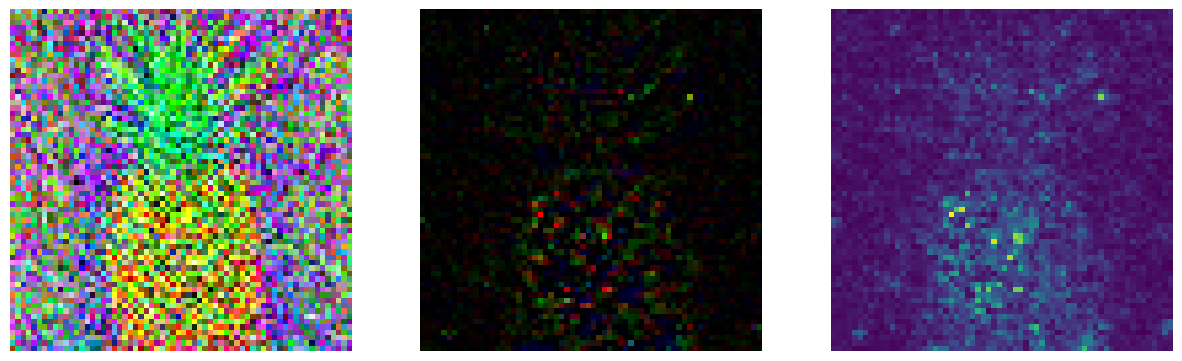

  4%|▍         | 45/1001 [00:18<06:04,  2.62it/s]

39257.5 Loss
tensor(-0.7325, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.7006, device='cuda:0', grad_fn=<MaxBackward1>) Target


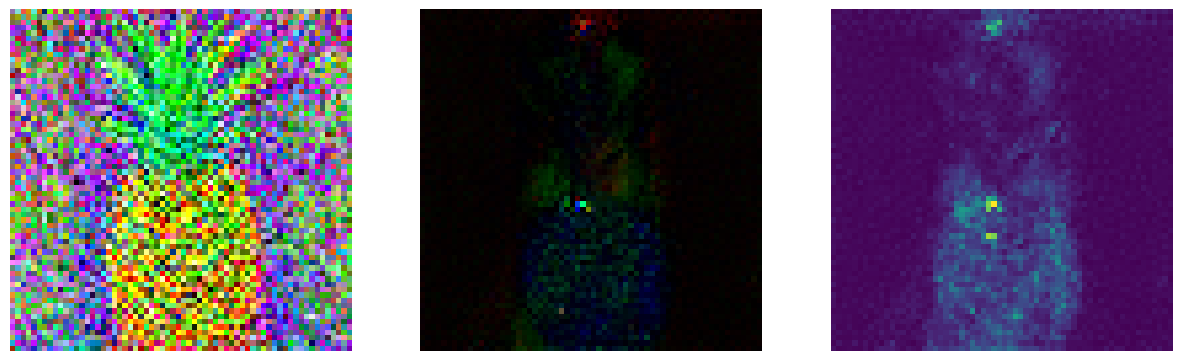

  5%|▍         | 50/1001 [00:20<06:01,  2.63it/s]

29436.203125 Loss
tensor(-0.9054, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.8035, device='cuda:0', grad_fn=<MaxBackward1>) Target


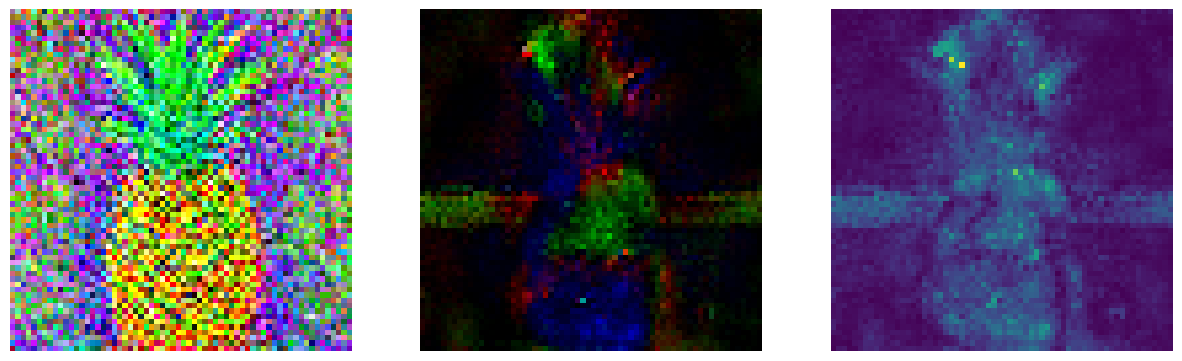

  5%|▌         | 55/1001 [00:22<05:59,  2.63it/s]

1481.791015625 Loss
tensor(-1.0198, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.9427, device='cuda:0', grad_fn=<MaxBackward1>) Target


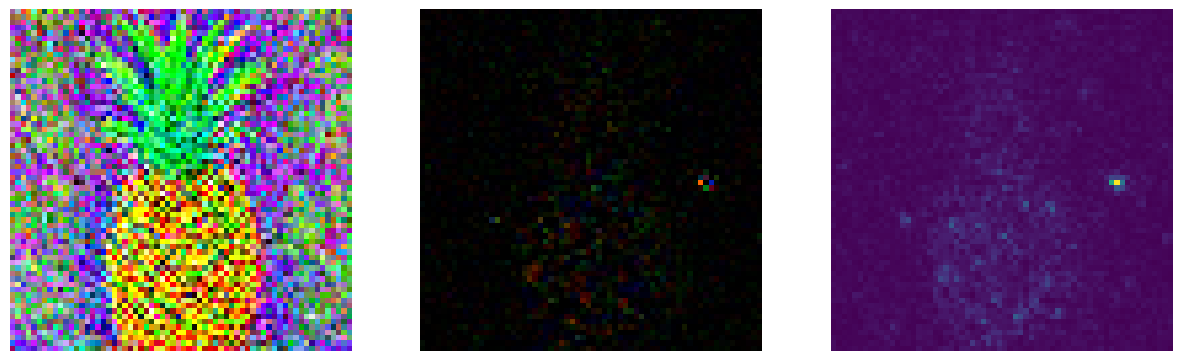

  6%|▌         | 60/1001 [00:24<05:59,  2.62it/s]

21508.19921875 Loss
tensor(-1.1917, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.0453, device='cuda:0', grad_fn=<MaxBackward1>) Target


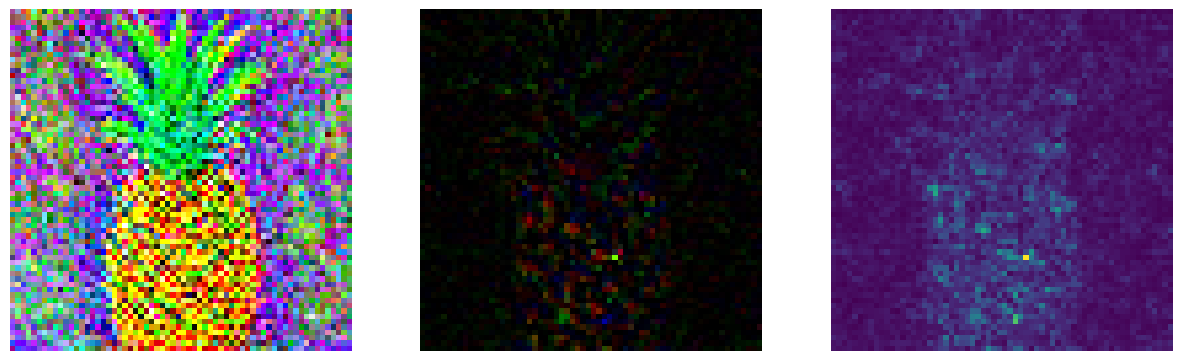

  6%|▋         | 65/1001 [00:26<05:58,  2.61it/s]

35199.51171875 Loss
tensor(-1.4782, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.2481, device='cuda:0', grad_fn=<MaxBackward1>) Target


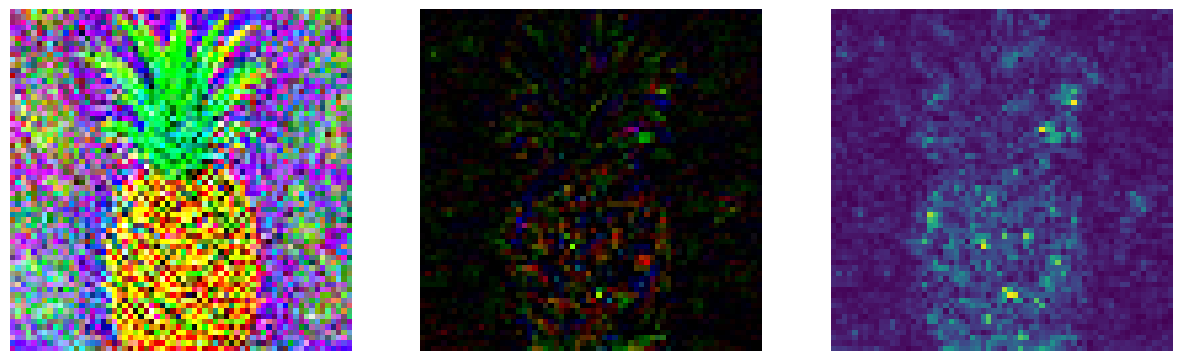

  7%|▋         | 70/1001 [00:28<05:57,  2.60it/s]

129.93618774414062 Loss
tensor(-1.6095, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.3758, device='cuda:0', grad_fn=<MaxBackward1>) Target


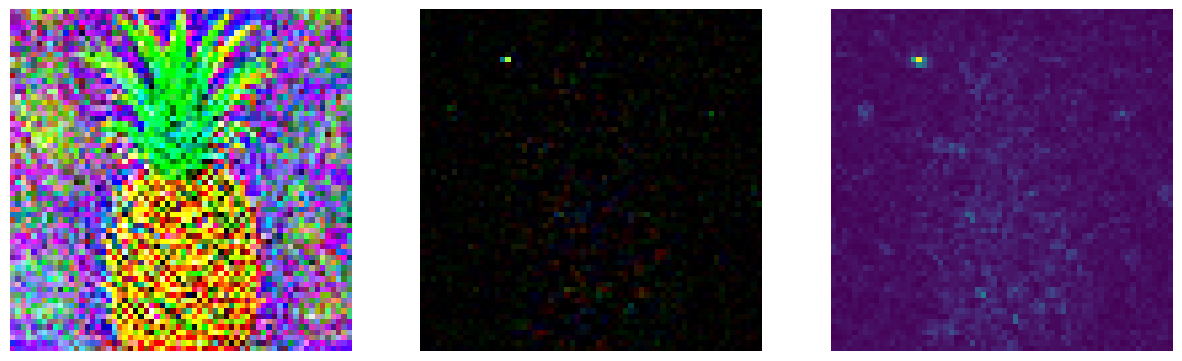

  7%|▋         | 75/1001 [00:30<05:53,  2.62it/s]

114228.6875 Loss
tensor(-1.7322, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.4838, device='cuda:0', grad_fn=<MaxBackward1>) Target


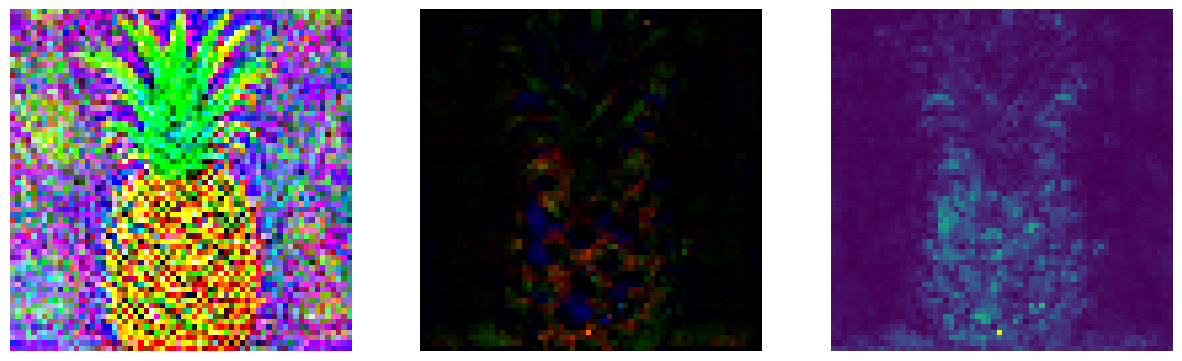

  8%|▊         | 80/1001 [00:32<05:51,  2.62it/s]

13603.021484375 Loss
tensor(-1.8756, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.4755, device='cuda:0', grad_fn=<MaxBackward1>) Target


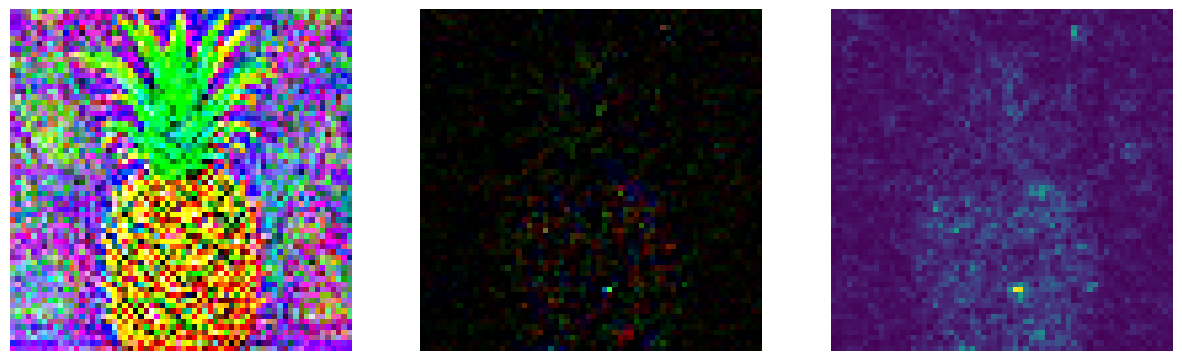

  8%|▊         | 85/1001 [00:34<05:51,  2.61it/s]

44999.96484375 Loss
tensor(-2.0384, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.5317, device='cuda:0', grad_fn=<MaxBackward1>) Target


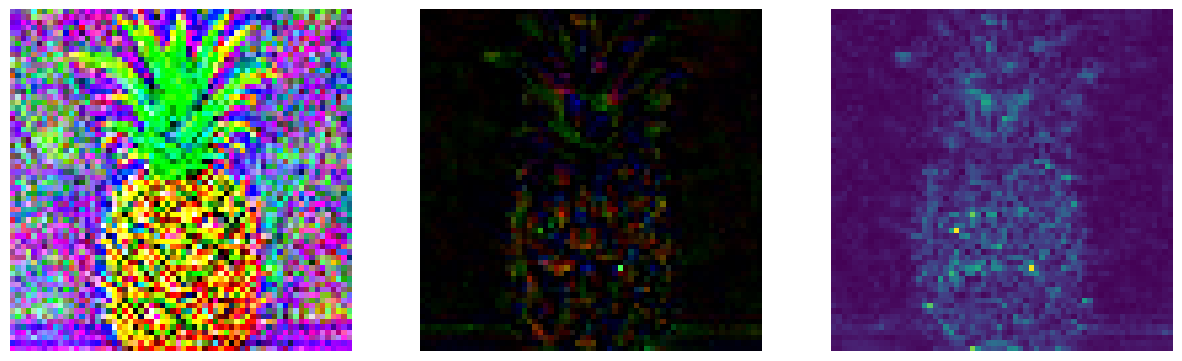

  9%|▉         | 90/1001 [00:36<05:53,  2.58it/s]

41483.9453125 Loss
tensor(-2.2197, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.6428, device='cuda:0', grad_fn=<MaxBackward1>) Target


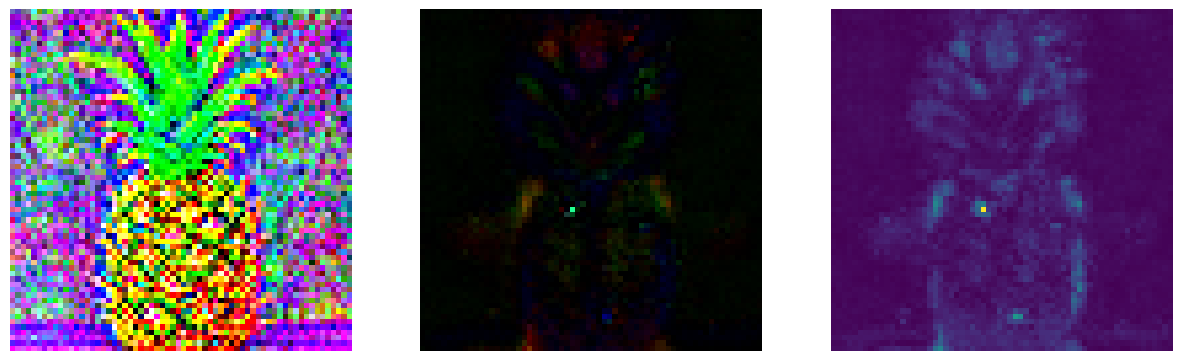

  9%|▉         | 92/1001 [00:37<06:11,  2.45it/s]

Optimizing process:


interactive(children=(IntSlider(value=1, description='index', max=18), Output()), _dom_classes=('widget-intera…

Output()

In [13]:
config['mode'] = 'rgb'
run(config)